<a href="https://colab.research.google.com/github/rrezendes/ecommerce_cohort_analysis/blob/master/analise_cohort_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort Analysis

# 1. Importação

In [0]:
#@title
#importação de  bibliotecas
import pandas as pd

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#link do arquivo no google drive
link = 'https://drive.google.com/open?id=1IFVPkvhdeSamneRA5rspQfLWQaYj7HMo' # The shareable link

#pega o ID do arquivo no google drive
fluff, id = link.split('=')

#download e leitura do csv
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ecommerce_sales.csv')  
base_csv = pd.read_csv('ecommerce_sales.csv')

In [0]:
base_csv

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [0]:
df = base_csv

#converter colunas para formato data
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

#criar novo campo InvoiceMonth
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')

#criar novo campo TotalPrice
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

In [0]:
df.set_index('CustomerID', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['InvoiceMonth'].min()
df.reset_index(inplace=True)
df.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,InvoiceMonth,TotalPrice,CohortGroup
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,2010-12,15.30,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12
2,17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,2010-12,22.00,2010-12
3,17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12
4,17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12


In [0]:
import numpy as np

grouped = df.groupby(['CohortGroup', 'InvoiceMonth'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'CustomerID': pd.Series.nunique,
                       'InvoiceNo': pd.Series.nunique,
                       'TotalPrice': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'CustomerID': 'TotalCustomer',
                        'InvoiceNo': 'TotalInvoice'}, inplace=True)
cohorts.head()

TotalCustomer  TotalInvoice  TotalPrice
CohortGroup InvoiceMonth                                         
2010-12     2010-12               948.0          1708   554604.02
            2011-01               362.0           689   271616.52
            2011-02               317.0           579   230856.22
            2011-03               367.0           753   302509.39
            2011-04               341.0           611   200927.98

In [0]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalCustomer  TotalInvoice  TotalPrice  CohortPeriod
CohortGroup InvoiceMonth                                                       
2010-12     2010-12               948.0          1708   554604.02             1
            2011-01               362.0           689   271616.52             2
            2011-02               317.0           579   230856.22             3
            2011-03               367.0           753   302509.39             4
            2011-04               341.0           611   200927.98             5

In [0]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalCustomer'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2010-12    948.0
2011-01    421.0
2011-02    380.0
2011-03    440.0
2011-04    299.0
Name: TotalCustomer, dtype: float64

In [0]:
user_retention = cohorts['TotalCustomer'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CohortPeriod,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.381857,0.239905,0.247368,0.190909,0.227425,0.236559,0.208511,0.209424,0.251497,0.298658,0.264205,0.133956,NaN
3,0.334388,0.282660,0.192105,0.254545,0.220736,0.172043,0.187234,0.204188,0.251497,0.325503,0.130682,NaN,NaN
4,0.387131,0.242280,0.278947,0.218182,0.210702,0.172043,0.272340,0.230366,0.251497,0.120805,NaN,NaN,NaN
5,0.359705,0.327791,0.268421,0.231818,0.207358,0.215054,0.246809,0.272251,0.137725,NaN,NaN,NaN,NaN
6,0.396624,0.299287,0.247368,0.177273,0.237458,0.243728,0.336170,0.115183,NaN,NaN,NaN,NaN,NaN
7,0.379747,0.261283,0.255263,0.263636,0.230769,0.265233,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
8,0.354430,0.256532,0.281579,0.238636,0.260870,0.103943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.354430,0.311164,0.257895,0.288636,0.083612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


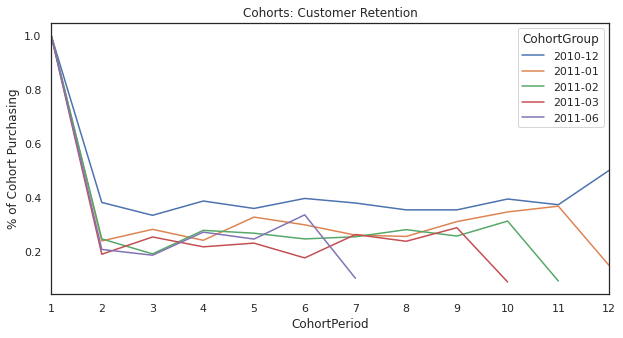

In [0]:

user_retention[['2010-12','2011-01', '2011-02', '2011-03','2011-06']].plot(figsize=(10,5))
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

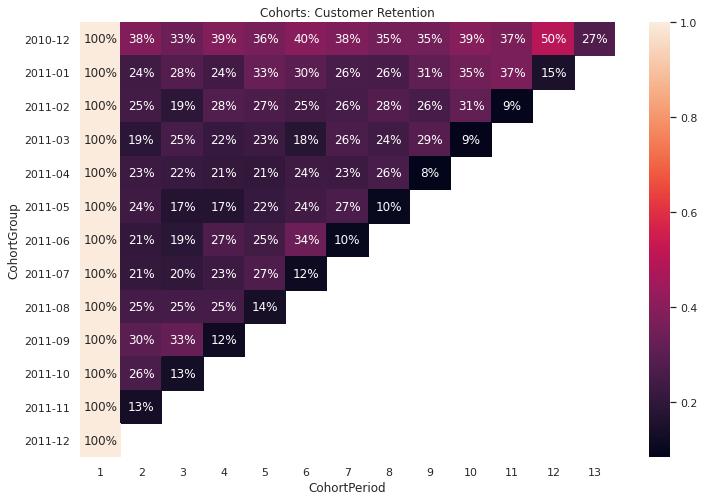

In [0]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Customer Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

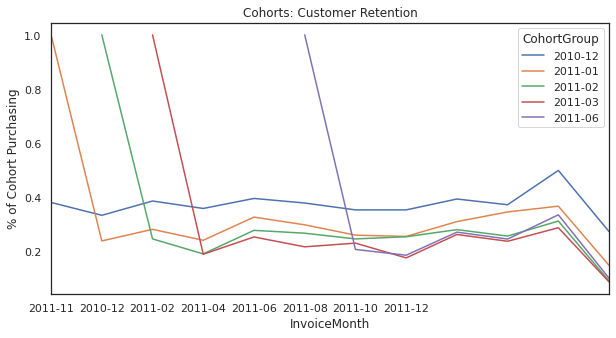

In [0]:

user_retention[['2010-12','2011-01', '2011-02', '2011-03','2011-06']].plot(figsize=(10,5))
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

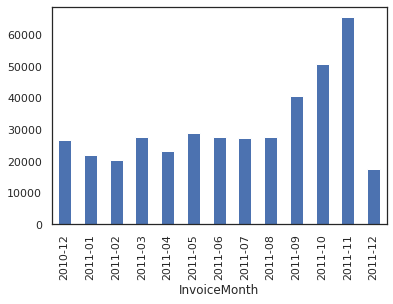

In [0]:
df.groupby('InvoiceMonth').CustomerID.count().plot.bar()

In [0]:
df.groupby('InvoiceMonth').CustomerID.count()

InvoiceMonth
2010-12    26850
2011-01    21912
2011-02    20363
2011-03    27822
2011-04    23198
2011-05    28908
2011-06    27836
2011-07    27502
2011-08    27662
2011-09    40822
2011-10    50695
2011-11    65598
2011-12    17661
Name: CustomerID, dtype: int64